# CT5165 Principles of Machine Learning Assignment 3

### Jiarong Li

### ID 20230033, 1MA1

## Introduction

The goal of this assignment is for you to gain practical experience of performing regression on a real world dataset. This is the code part.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder # one hot encoding
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.svm import SVR

from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Dataset

Each row describes one individual instance in the dataset. 

The attributes in train.csv are in columns in the following order:

ID, temperature, var1, pressure, windspeed, var2, and electricity_consumption.

The test.csv file is same as train however, the electricity_consumption column is missing.

In this dataset, one or more of the attributes e.g. var2 are categorical and others are continuous. 

The values (A, B, or C) in this attribute do not have a natural ordering. 

It will be necessary to encode the categorical attributes as numeric values using ordinal encoding or one-hot encoding before applying your chosen regression algorithms. 

For a further information on how to encode categorical variables, you may wish to consult the following free online resources:
https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

### Data pre-processing

In [2]:
def data_preprocess(data_path, train=True):
    df = pd.read_csv(data_path, 
                     header=0, 
                     parse_dates=['datetime'], infer_datetime_format=True
                    )
    #df_original = train_df
    #one_hot_encoder = OneHotEncoder(sparse=False)
    orinal_encoder = OrdinalEncoder()
    
    df['Year'] = df.datetime.dt.year
    df['Month'] = df.datetime.dt.month
    time = np.array(df.datetime.dt.time).reshape(-1, 1)
    df['Time'] = orinal_encoder.fit_transform(time)
    

    var2 = np.array(df["var2"]).reshape(-1, 1)
    
    var_2_ordinal = orinal_encoder.fit_transform(var2) # transform data
    df["var_2_ordinal"] = var_2_ordinal #.tolist()
    
    if train == True:
        labels = df["electricity_consumption"].to_numpy()
        df = df.drop(columns=["datetime", "ID", "var2", "electricity_consumption"])

    else:
        df = df.drop(columns=["datetime", "ID", "var2"])
        labels = np.array([])
    
    X = df.to_numpy()

    return X, labels

In [3]:
train_data_path = "Electricity-Consumption/train.csv"
test_data_path = "Electricity-Consumption/test.csv"

In [4]:
X_train, y_train = data_preprocess(train_data_path)
print(X_train.shape)
print(y_train.shape)

(26496, 8)
(26496,)


In [6]:
X_test, none = data_preprocess(test_data_path, train=False)
print(none.shape)
print(X_test.shape)

(0,)
(8568, 8)


## Models train, test and evaluation

### Linear Regression with k-fold cross validation and SVR

In [7]:
linear_regression = LinearRegression() # initialise a linear regression model
svr = SVR()

In [8]:
def cross_validation_train(model, X_train, y_train, n_splits=5):
    linear_regressions = []
    scores = []
    
    kfolds = KFold(n_splits = n_splits, shuffle = True, random_state = 100) # create a KFold object with 5 splits 
        
    for train, validation in kfolds.split(X_train, y_train):
        model.fit(X_train[train], y_train[train])
        score = model.score(X_train[validation], y_train[validation])
        print(score)

In [9]:
cross_validation_train(linear_regression, X_train, y_train)

0.22725899003878047
0.2342635646288337
0.22989172253012824
0.2221357842795294
0.22698580904309362


In [10]:
cross_validation_train(svr, X_train, y_train)

-0.060691737685950375
-0.0583412957169569
-0.05688905127369748
-0.06295839291040073
-0.05736624994330941


#### Using Grid Search Cross Validation to find the optimal number of features.

ref: https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression#0.-Experiments-to-Understand-Overfitting

In [11]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, len(X_train[0])))}]

# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7]}],
             return_train_score=True, scoring='r2', verbose=1)

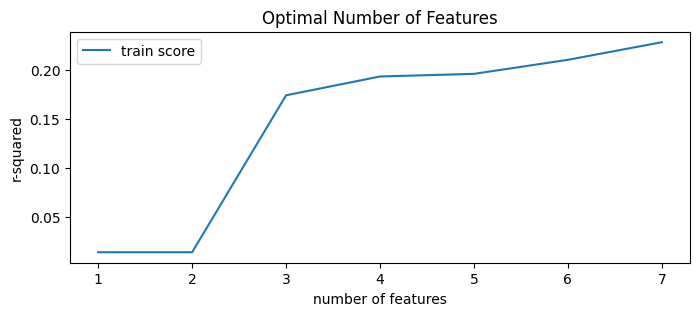

In [12]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

# plotting cv results
plt.figure(figsize=(8,3))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['train score'], loc='upper left');

In [13]:
# final linear regression model
elec_comsu_linear_regression = LinearRegression()

poly = PolynomialFeatures(5)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

epochs = 5

# evaluation
r2_score = 0.0
mean_absolute_error = 0.0
mean_squared_error = 0.0

for epoch in range(epochs): # train 5 epochs
        
    elec_comsu_linear_regression.fit(X_train_, y_train)
    
    y_predict = elec_comsu_linear_regression.predict(X_train_)
    
    r2_score += metrics.r2_score(y_train, y_predict)
    mean_absolute_error += metrics.mean_absolute_error(y_train, y_predict)
    mean_squared_error += metrics.mean_squared_error(y_train, y_predict)

print(f"avg_r2_score = {r2_score / epochs}")
print(f"avg_mean_absolute_error = {mean_absolute_error / epochs}")
print(f"avg_mean_squared_error = {mean_squared_error / epochs}")
    
test_predict_lr = elec_comsu_linear_regression.predict(X_test_)

avg_r2_score = 0.4820916096873241
avg_mean_absolute_error = 54.71542206824114
avg_mean_squared_error = 6042.955092644243


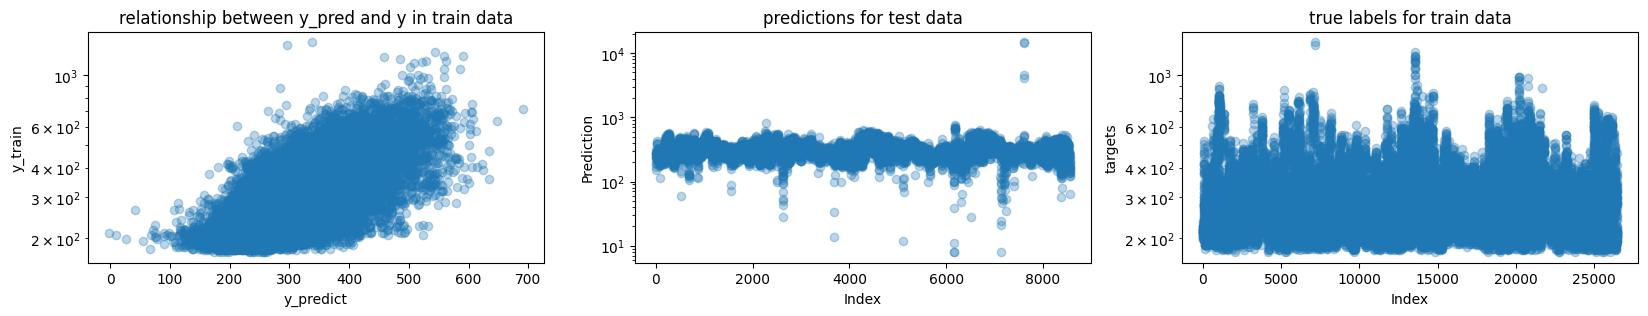

In [16]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(20, 3))

# train data
plt.subplot(131)
plt.scatter(y_predict, y_train, alpha=0.3)
plt.yscale('log')
plt.title("relationship between y_pred and y in train data")
#plt.legend(loc='upper left')
plt.xlabel("y_predict")
plt.ylabel("y_train");
  
# test data
plt.subplot(132)
plt.scatter(range(len(X_test)), test_predict_lr, alpha=0.3)
plt.yscale('log')
plt.title("predictions for test data")
plt.xlabel("Index")
plt.ylabel("Prediction");


plt.subplot(133)
plt.scatter(range(len(X_train)), y_train, alpha=0.3)
plt.yscale('log')
plt.title("true labels for train data")
plt.xlabel("Index")
plt.ylabel("targets");

In [24]:
# final svr model
elec_comsu_svr = SVR()

# poly = PolynomialFeatures(2)
# X_train_ = poly.fit_transform(X_train)
# X_test_ = poly.fit_transform(X_test)

epochs = 5

# evaluation
r2_score = 0.0
mean_absolute_error = 0.0
mean_squared_error = 0.0


for epoch in range(epochs): # train 5 epochs
    elec_comsu_svr.fit(X_train, y_train)
    
    y_predict = elec_comsu_svr.predict(X_train)
    
    r2_score += metrics.r2_score(y_train, y_predict)
    mean_absolute_error += metrics.mean_absolute_error(y_train, y_predict)
    mean_squared_error += metrics.mean_squared_error(y_train, y_predict)

print(f"avg_r2_score = {r2_score / epochs}")
print(f"avg_mean_absolute_error = {mean_absolute_error / epochs}")
print(f"avg_mean_squared_error = {mean_squared_error / epochs}")
    
test_predict_svr = elec_comsu_svr.predict(X_test)

avg_r2_score = -0.05700711173734874
avg_mean_absolute_error = 74.5757678118383
avg_mean_squared_error = 12333.158968477252


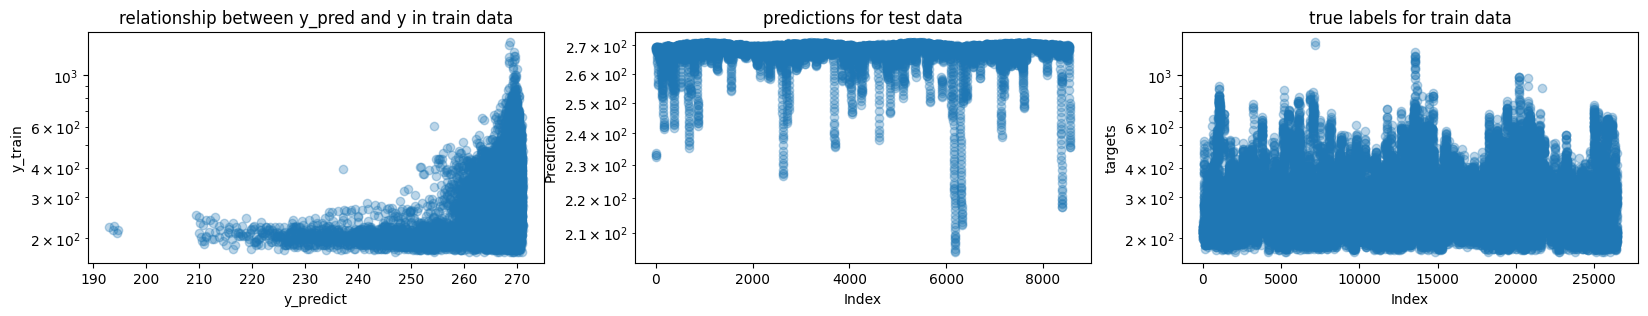

In [23]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(20, 3))

# train data
plt.subplot(131)
plt.scatter(y_predict, y_train, alpha=0.3)
plt.yscale('log')
plt.title("relationship between y_pred and y in train data")
#plt.legend(loc='upper left')
plt.xlabel("y_predict")
plt.ylabel("y_train");
  
# test data
plt.subplot(132)
plt.scatter(range(len(X_test)), test_predict_svr, alpha=0.3)
plt.yscale('log')
plt.title("predictions for test data")
plt.xlabel("Index")
plt.ylabel("Prediction");


plt.subplot(133)
plt.scatter(range(len(X_train)), y_train, alpha=0.3)
plt.yscale('log')
plt.title("true labels for train data")
plt.xlabel("Index")
plt.ylabel("targets");

In [25]:
# make a new csv with predicted data
def predicted_df(test_data_path, test_predict, new_path, model):
    pred_df = pd.read_csv(test_data_path, 
                     header=0, 
                     parse_dates=['datetime'], infer_datetime_format=True
                    )
    pred_df[f"{model}_predicted_electricity_comsumption"] = test_predict
    
    pred_df.to_csv(new_path)
    
    return pred_df

In [26]:
pred_df = predicted_df(test_data_path, test_predict_lr, "lr_predicted_electricity_comsumption.csv", "lr")
pred_df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,lr_predicted_electricity_comsumption
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A,194.544052
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A,186.980331
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A,170.855331
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A,148.791855
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A,289.327499


In [27]:
pred_df = predicted_df(test_data_path, test_predict_svr, "lr_predicted_electricity_comsumption.csv", "svr")
pred_df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,svr_predicted_electricity_comsumption
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A,233.383734
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A,232.718444
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A,232.602130
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A,231.955919
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A,269.546254
